In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from pycm import *
from PIL import Image, ImageFile
import seaborn as sns
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable

In [2]:
DATA_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/'
TRAIN_DIR = DATA_DIR + 'Final_Images/train_img_final/'
TEST_DIR = DATA_DIR + 'Final_Images/test_img_final/'

# load train images annotations
train_info = json.load(open(DATA_DIR + 'iwildcam2020_train_annotations.json'))
# split json into several pandas dataframes
train_annotations = pd.DataFrame(train_info['annotations'])
train_images = pd.DataFrame(train_info['images'])
train_categories = pd.DataFrame(train_info['categories'])

# load test images info
test_info = json.load(open(DATA_DIR + 'iwildcam2020_test_information.json'))
# split json into several pandas dataframes
test_images = pd.DataFrame(test_info['images'])
test_categories = pd.DataFrame(test_info['categories'])

megadetector_results = json.load(open(DATA_DIR + 'iwildcam2020_megadetector_results.json'))
mega_images = pd.DataFrame(megadetector_results['images'])

In [4]:
pd.set_option('display.max_rows', 500)
train_categories.sort_values('count', ascending=False)

count   id                       name
0    78981    0                      empty
36   33313   75                      human
188  16713  372         meleagris ocellata
189  12908  374                 crax rubra
146   9052  317     cephalophus nigrifrons
48    8517   96         aepyceros melampus
1     6355    2             tayassu pecari
2     5833    3        dasyprocta punctata
8     5824   10         leopardus pardalis
32    5118   71                 bos taurus
187   4542  371   urocyon cinereoargenteus
238   4477  647        dasyprocta leporina
4     4453    6              puma concolor
17    4099   24              panthera onca
195   3921  380              mazama temama
44    3614   90         loxodonta africana
191   3452  376            tapirus bairdii
65    3426  115          madoqua guentheri
223   3120  558                 motorcycle
190   2959  375                agouti paca
45    2630   91       cricetomys gambianus
39    2500   79                    unknown
61    2297  111               equus quagga
113   1937  243               didelphis sp
145   1849  316      cercopithecus lhoesti
105   1841  227          psophia crepitans
60    1755  110            syncerus caffer
62    1499  112     giraffa camelopardalis
111   1366  240               nasua narica
193   1343  378     odocoileus virginianus
144   1324  315        francolinus nobilis
194   1300  379      leptotila plumbeiceps
239   1291  648               crax alector
19    1284   26              tinamus major
6     1181    8              pecari tajacu
197   1119  384             mazama pandora
51    1099   99                equus ferus
122   1015  259               equus grevyi
79    1006  137          macaca nemestrina
147    973  318        atherurus africanus
66     915  116     potamochoerus larvatus
83     887  144          muntiacus muntjak
130    810  290             unidentifiable
150    787  321    funisciurus carruthersi
245    784  654          unknown armadillo
237    761  599       unknown mouse or rat
121    620  258       acryllium vulturinum
3      619    4             cuniculus paca
80     570  139           argusianus argus
38     562   78               papio anubis
119    545  256        camelus dromedarius
114    510  245      penelope purpurascens
243    508  652           myoprocta pratii
9      480   12          geotrygon montana
27     458   50           leopardus wiedii
55     449  103     phacochoerus africanus
250    393  659             tayassu tajacu
231    380  566                 sciurus sp
177    346  348                        end
49     338   97            crocuta crocuta
31     333   70             capra aegagrus
141    333  309   capricornis sumatraensis
7      330    9           mazama americana
142    330  310        macaca fascicularis
204    315  404                    misfire
100    300  179        leptotila rufaxilla
241    289  650            unknown opossum
148    287  319            pan troglodytes
12     260   15               eira barbara
87     254  152          hystrix brachyura
224    254  559              peromyscus sp
84     251  145                 sus scrofa
176    249  347                      start
53     248  101           tragelaphus oryx
246    245  655        mazama gouazaoubira
232    230  567            ave desconocida
157    223  328    cephalophus silvicultor
33     195   72                 ovis aries
233    195  568           aramides cajanea
18     187   25    myrmecophaga tridactyla
149    184  320        cercopithecus mitis
11     183   14       dasypus novemcinctus
14     167   17          penelope jacquacu
251    161  660             mitu tomentosa
54     160  102       kobus ellipsiprymnus
192    146  377              procyon lotor
226    130  561             unknown raptor
5      129    7         tapirus terrestris
85     128  147        helarctos malayanus
35     122   74            lepus saxatilis
198    120  385             ortalis vetula
230    120  565          claravis pretiosa
173   

In [7]:
df_train = pd.merge(train_annotations, train_images, how='outer', left_on='image_id', right_on='id')
df_train = df_train.drop(['id_y'], axis=1)

df_train['Date'] = pd.to_datetime(df_train['datetime']).dt.date
df_train = df_train.astype({'Date': str})
df_train['Time'] = pd.to_datetime(df_train['datetime']).dt.time
df_train = df_train.astype({'Time': str})

df_train['Year'] = df_train['Date'].str.slice(0, 4, 1)
df_train = df_train.astype({'Year': int})
df_train['Month'] = df_train['Date'].str.slice(5, 7, 1)
df_train = df_train.astype({'Month': int})
df_train['Day'] = df_train['Date'].str.slice(8, 10, 1)
df_train = df_train.astype({'Day': int})

df_train['Hour'] = df_train['Time'].str.slice(0, 2, 1)
df_train = df_train.astype({'Hour': int})
df_train['Min'] = df_train['Time'].str.slice(3, 5, 1)
df_train = df_train.astype({'Min': int})
df_train['Sec'] = df_train['Time'].str.slice(6, 8, 1)
df_train = df_train.astype({'Sec': int})

df_train = df_train.drop(['Date', 'Time'], axis=1)

df_train.columns = ['animal_cnt', 'image_id', 'id', 'category_id', 'seq_num_frames', 'location', 'datetime', 'frame_num', 'seq_id', 'width', 'height', 'file_name', 'year',
                    'month', 'day', 'hour', 'min', 'sec']

df_train = df_train[['id', 'seq_id', 'image_id', 'file_name', 'width', 'height', 'seq_num_frames', 'frame_num', 'datetime', 'location', 'animal_cnt', 'year',
                     'month', 'day', 'hour', 'min', 'sec', 'category_id']]

df_train['category_id'] = df_train['category_id'].apply(str)

df_train.head(5)

id                                seq_id  \
0  a292dd3c-21bc-11ea-a13a-137349068a90  96b004ea-21bc-11ea-a13a-137349068a90   
1  a0afcfc0-21bc-11ea-a13a-137349068a90  879d7654-21bc-11ea-a13a-137349068a90   
2  a306e9c0-21bc-11ea-a13a-137349068a90  9017f8cc-21bc-11ea-a13a-137349068a90   
3  9eed94c4-21bc-11ea-a13a-137349068a90  90d93e38-21bc-11ea-a13a-137349068a90   
4  a2a4dd7a-21bc-11ea-a13a-137349068a90  887cd29a-21bc-11ea-a13a-137349068a90   

                               image_id  \
0  96b00332-21bc-11ea-a13a-137349068a90   
1  879d74d8-21bc-11ea-a13a-137349068a90   
2  9017f7aa-21bc-11ea-a13a-137349068a90   
3  90d93c58-21bc-11ea-a13a-137349068a90   
4  887cd0ec-21bc-11ea-a13a-137349068a90   

                                  file_name  width  height  seq_num_frames  \
0  96b00332-21bc-11ea-a13a-137349068a90.jpg   1795    1222               1   
1  879d74d8-21bc-11ea-a13a-137349068a90.jpg   2739    1772               1   
2  9017f7aa-21bc-11ea-a13a-137349068a90.jpg   1891    1222               1   
3  90d93c58-21bc-11ea-a13a-137349068a90.jpg   1795    1222               1   
4  887cd0ec-21bc-11ea-a13a-137349068a90.jpg   1812    1196               1   

   frame_num                 datetime  location  animal_cnt  year  month  day  \
0          1  2013-08-08 11:45:00.000       267           1  2013      8    8   
1          1  2013-08-01 22:31:00.000       264           1  2013      8    1   
2          1  2013-04-17 11:15:00.000        45           1  2013      4   17   
3          1  2013-04-23 08:26:00.000        45           1  2013      4   23   
4          1  2013-04-24 13:51:00.000        45           1  2013      4   24   

   hour  min  sec category_id  
0    11   45    0          73  
1    22   31    0           4  
2    11   15    0         227  
3     8   26    0         250  
4    13   51    0           2

In [8]:
corrupted_files = ['87022118-21bc-11ea-a13a-137349068a90.jpg',
                   '8f17b296-21bc-11ea-a13a-137349068a90.jpg',
                   '883572ba-21bc-11ea-a13a-137349068a90.jpg',
                   '896c1198-21bc-11ea-a13a-137349068a90.jpg',
                   '8792549a-21bc-11ea-a13a-137349068a90.jpg',
                   '99136aa6-21bc-11ea-a13a-137349068a90.jpg']

for corrupted_file in corrupted_files:
    df_train = df_train[df_train['file_name'] != corrupted_file]

In [6]:
data_dir = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/Final_Images/train_img_final'
batch_size = 16

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [8]:
def load_split_train_test(datadir, valid_size = .2):
    train_transforms = transforms.Compose([transforms.Resize(224),
                                           transforms.RandomHorizontalFlip(p=0.5),
                                           transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=None, shear=24),
                                       transforms.ToTensor(),
                                       ])
    test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                      ])
    train_data = datasets.ImageFolder(datadir,       
                    transform=train_transforms)
    test_data = datasets.ImageFolder(datadir,
                    transform=test_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    from torch.utils.data.sampler import SubsetRandomSampler
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=batch_size)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=batch_size)
    return trainloader, testloader

In [9]:
trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['0', '10', '100', '101', '102', '103', '104', '106', '108', '110', '111', '112', '113', '114', '115', '116', '118', '119', '12', '120', '121', '122', '123', '124', '127', '129', '13', '130', '133', '134', '137', '139', '14', '141', '142', '144', '145', '147', '15', '150', '152', '153', '154', '156', '159', '16', '161', '162', '163', '166', '167', '170', '175', '177', '198', '2', '20', '221', '227', '229', '230', '233', '234', '235', '24', '240', '242', '243', '245', '25', '250', '251', '252', '253', '256', '257', '258', '259', '26', '262', '265', '267', '268', '273', '286', '290', '291', '292', '294', '296', '299', '3', '300', '301', '302', '306', '307', '309', '310', '315', '316', '317', '318', '319', '32', '320', '321', '322', '323', '324', '325', '326', '327', '328', '330', '332', '333', '334', '335', '336', '337', '338', '339', '340', '341', '342', '344', '345', '346', '347', '348', '349', '350', '352', '353', '354', '355', '356', '357', '370', '371', '372', '374', '375', '376', '

In [10]:
model = models.resnet50(pretrained=True)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(nn.Linear(2048, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                         nn.Linear(512, 512),
                                 nn.ReLU(),
                                 nn.Dropout(0.2),
                         nn.Linear(512, 216),
                                 nn.LogSoftmax(dim=1))
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [12]:
epochs = 100
steps = 0
total_steps = len(trainloader)
running_loss = 0
print_every = int(total_steps/100)
train_losses, test_losses = [], []
epoch_test_losses = []
prev_epoch_loss = 1000 # Some very high number
prev_epoch_acc = 0
stop_crit = 0.01
for epoch in range(epochs):
    steps = 0
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            #with torch.no_grad():
            #    for inputs, labels in testloader:
            #        inputs, labels = inputs.to(device), labels.to(device)
            #        logps = model.forward(inputs)
            #        batch_loss = criterion(logps, labels)
            #        test_loss += batch_loss.item()
                    
            #        ps = torch.exp(logps)
            #        top_p, top_class = ps.topk(1, dim=1)
            #        equals = top_class == labels.view(*top_class.shape)
            #        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            #train_losses.append(running_loss/print_every)
            #test_losses.append(test_loss/len(testloader))
            #epoch_test_losses.append(test_loss/len(testloader))
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Steps {steps+1}/{total_steps}.. ")
                  #f"Train loss: {running_loss/print_every:.3f}.. "
                  #f"Test loss: {test_loss/len(testloader):.3f}.. "
                  #f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()
    
    test_loss = 0
    accuracy = 0
    model.eval()
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            logps = model.forward(inputs)
            batch_loss = criterion(logps, labels)
            test_loss += batch_loss.item()
            
            ps = torch.exp(logps)
            top_p, top_class = ps.topk(1, dim=1)
            equals = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
    test_loss = test_loss/len(testloader)
    accuracy = accuracy/len(testloader)
    
    print(f"Epoch Test Loss: {test_loss}.. "
          f"Prev Epoch Test Loss {prev_epoch_loss}.. "
          f"Accuracy {accuracy}.. ")
    
    if test_loss > prev_epoch_loss - stop_crit and accuracy < prev_epoch_acc + (stop_crit/10):
        break

    prev_epoch_loss = test_loss
    prev_epoch_acc = accuracy

Epoch 1/100.. Steps 109/10898.. 
Epoch 1/100.. Steps 217/10898.. 
Epoch 1/100.. Steps 325/10898.. 
Epoch 1/100.. Steps 433/10898.. 
Epoch 1/100.. Steps 541/10898.. 
Epoch 1/100.. Steps 649/10898.. 
Epoch 1/100.. Steps 757/10898.. 
Epoch 1/100.. Steps 865/10898.. 
Epoch 1/100.. Steps 973/10898.. 
Epoch 1/100.. Steps 1081/10898.. 
Epoch 1/100.. Steps 1189/10898.. 
Epoch 1/100.. Steps 1297/10898.. 
Epoch 1/100.. Steps 1405/10898.. 
Epoch 1/100.. Steps 1513/10898.. 
Epoch 1/100.. Steps 1621/10898.. 
Epoch 1/100.. Steps 1729/10898.. 
Epoch 1/100.. Steps 1837/10898.. 
Epoch 1/100.. Steps 1945/10898.. 
Epoch 1/100.. Steps 2053/10898.. 
Epoch 1/100.. Steps 2161/10898.. 
Epoch 1/100.. Steps 2269/10898.. 
Epoch 1/100.. Steps 2377/10898.. 
Epoch 1/100.. Steps 2485/10898.. 
Epoch 1/100.. Steps 2593/10898.. 
Epoch 1/100.. Steps 2701/10898.. 
Epoch 1/100.. Steps 2809/10898.. 
Epoch 1/100.. Steps 2917/10898.. 
Epoch 1/100.. Steps 3025/10898.. 
Epoch 1/100.. Steps 3133/10898.. 
Epoch 1/100.. Steps 324

In [13]:
torch.save(model, 'iwildcam_2.pth')

In [14]:
#plt.plot(train_losses, label='Training loss')
#plt.plot(test_losses, label='Validation loss')
#plt.legend(frameon=False)
#plt.show()

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=torch.load('iwildcam_2.pth')
#model=torch.load('iwildcam_best.pth')
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
test_transforms = transforms.Compose([transforms.Resize(224),
                                      transforms.ToTensor(),
                                     ])

In [17]:
data = datasets.ImageFolder(data_dir, transform=test_transforms)
classes = data.classes

In [18]:
def predict_image(image):
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    input = input.to(device)
    output = model(input)
    index = output.data.cpu().numpy().argmax()
    return index

In [19]:
categorical_train_labels = list(df_train['category_id'])

In [20]:
categorical_preds = []

count = 0
for file_name in df_train['file_name']:
    if count % 1000 == 0:
        print('Through ' + str(count) + ' images')
    
    filename = TRAIN_DIR + df_train['category_id'].iloc[count] + '/' + file_name
    
    img = Image.open(filename)
    categorical_preds.append(str(int(classes[predict_image(img)])))
    
    count += 1

Through 0 images
Through 1000 images
Through 2000 images
Through 3000 images
Through 4000 images
Through 5000 images
Through 6000 images
Through 7000 images
Through 8000 images
Through 9000 images
Through 10000 images
Through 11000 images
Through 12000 images
Through 13000 images
Through 14000 images
Through 15000 images
Through 16000 images
Through 17000 images
Through 18000 images
Through 19000 images
Through 20000 images
Through 21000 images
Through 22000 images
Through 23000 images
Through 24000 images
Through 25000 images
Through 26000 images
Through 27000 images
Through 28000 images
Through 29000 images
Through 30000 images
Through 31000 images
Through 32000 images
Through 33000 images
Through 34000 images
Through 35000 images
Through 36000 images
Through 37000 images
Through 38000 images
Through 39000 images
Through 40000 images
Through 41000 images
Through 42000 images
Through 43000 images
Through 44000 images
Through 45000 images
Through 46000 images
Through 47000 images
Throu

In [21]:
def plot_confusion_matrix(cm,normalize=False,title='Confusion matrix',annot=False,cmap="YlGnBu"):
    if normalize == True:
        df = pd.DataFrame(cm.normalized_matrix).T.fillna(0)
    else:
        df = pd.DataFrame(cm.matrix).T.fillna(0)
    ax = sns.heatmap(df,annot=annot,cmap=cmap)
    ax.set_title(title)
    ax.set(xlabel='Predict', ylabel='Actual')

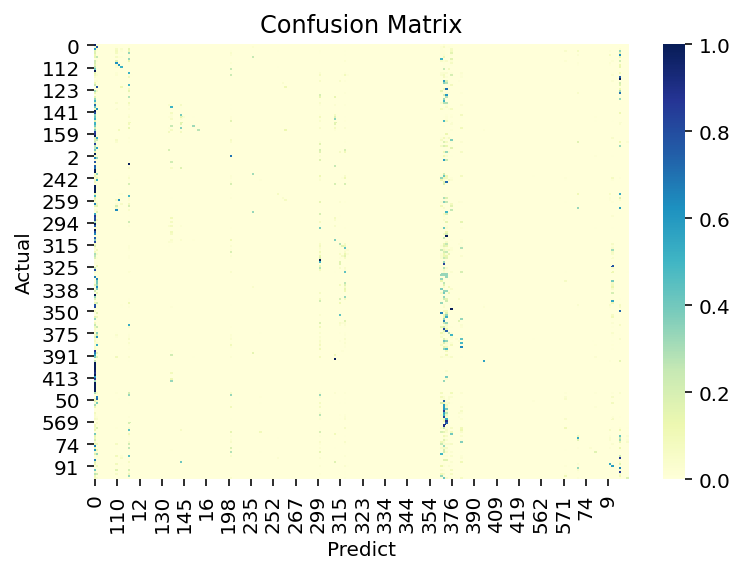

In [22]:
cm = ConfusionMatrix(actual_vector=categorical_train_labels, predict_vector=categorical_preds) # Create CM From Data
plot_confusion_matrix(cm,normalize=True,title="Confusion Matrix",annot=False)

In [23]:
path = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/cm_007.html'
cm.save_html(path, normalize=True)

{'Status': True,
 'Message': 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/cm_007.html.html'}

In [24]:
def get_random_images(num):
    data = datasets.ImageFolder(data_dir, transform=test_transforms)
    classes = data.classes
    indices = list(range(len(data)))
    np.random.shuffle(indices)
    idx = indices[:num]
    from torch.utils.data.sampler import SubsetRandomSampler
    sampler = SubsetRandomSampler(idx)
    loader = torch.utils.data.DataLoader(data, 
                   sampler=sampler, batch_size=num)
    dataiter = iter(loader)
    images, labels = dataiter.next()
    return images, labels

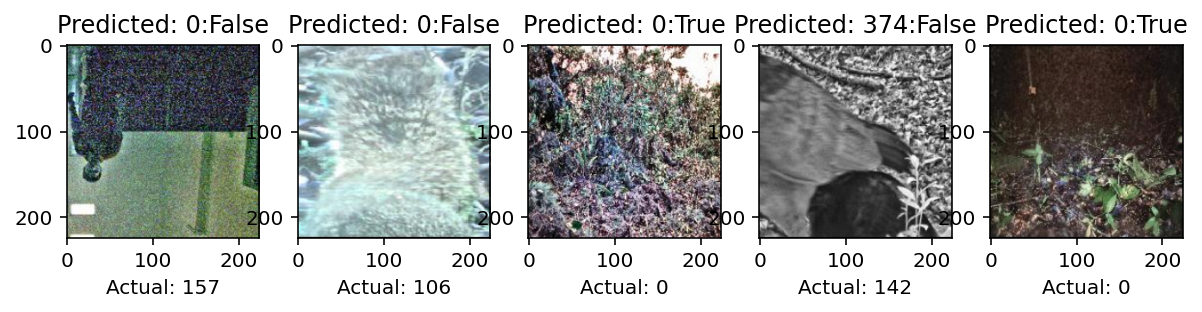

In [25]:
to_pil = transforms.ToPILImage()
images, labels = get_random_images(5)
fig=plt.figure(figsize=(10,10))
for ii in range(len(images)):
    image = to_pil(images[ii])
    index = predict_image(image)
    sub = fig.add_subplot(1, len(images), ii+1)
    res = str(int(labels[ii])) == str(classes[index])
    sub.set_title('Predicted: ' + str(classes[index]) + ":" + str(res))
    sub.set_xlabel('Actual: ' + str(int(labels[ii])))
    #plt.axis('off')
    plt.imshow(image)
plt.show()

In [26]:
DATA_DIR = 'C:/Users/BAB72/OneDrive/School Documents/DS_Principles/Final_Project/'
TRAIN_DIR = DATA_DIR + 'Final_Images/train_img_final/'
TEST_DIR = DATA_DIR + 'Final_Images/test_img_final/'

In [27]:
from PIL import Image, ImageFile

submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [28]:
count = 0
for ids in submission['Id']:
    if count % 1000 == 0:
        print('Through ' + str(count) + ' images')
    
    filename = TEST_DIR + ids + '.jpg'
    img = Image.open(filename)
    pred_cat = classes[predict_image(img)]
    
    #print(pred_cat)
    submission['Category'][count] = int(pred_cat)
    
    count += 1

Through 0 images


c:\users\bab72\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Through 1000 images
Through 2000 images
Through 3000 images
Through 4000 images
Through 5000 images
Through 6000 images
Through 7000 images
Through 8000 images
Through 9000 images
Through 10000 images
Through 11000 images
Through 12000 images
Through 13000 images
Through 14000 images
Through 15000 images
Through 16000 images
Through 17000 images
Through 18000 images
Through 19000 images
Through 20000 images
Through 21000 images
Through 22000 images
Through 23000 images
Through 24000 images
Through 25000 images
Through 26000 images
Through 27000 images
Through 28000 images
Through 29000 images
Through 30000 images
Through 31000 images
Through 32000 images
Through 33000 images
Through 34000 images
Through 35000 images
Through 36000 images
Through 37000 images
Through 38000 images
Through 39000 images
Through 40000 images
Through 41000 images
Through 42000 images
Through 43000 images
Through 44000 images
Through 45000 images
Through 46000 images
Through 47000 images
Through 48000 images
T

In [29]:
submission.to_csv(DATA_DIR + 'submission_017.csv', index=False)

In [ ]:
df_train[train_images['id'] == mega_images.iloc[i]['id']]['category_id']